# ルールでカウント
ルール整理
1人の回答者IDごとに

あるエリアに「好き」と「嫌い」両方の点があれば、そのエリアのカウントは0

好きだけなら好きカウント += 好き点の数

嫌いだけなら嫌いカウント += 嫌い点の数

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.path import Path
from collections import defaultdict
import japanize_matplotlib
from openpyxl import Workbook
import re

# ファイル読み込み
points_df = pd.read_csv("xy_points.csv")
data_df = pd.read_csv("a.csv")

In [2]:
#--------------------------------------
#  エリア定義ファイル
#--------------------------------------
area_polygons = {}
for name, group in points_df.groupby("name"):
    polygon = group[["x", "y"]].values
    area_polygons[name] = Path(polygon)  

#area_polygons

In [3]:
# IDごとに好き嫌いのエリアを一時保存する辞書
# 例: { respondent_idx: {area_name: {"like": n, "dislike": m}} }
per_respondent_area = defaultdict(lambda: defaultdict(lambda: {"like":0, "dislike":0}))
total_respondents = len(data_df)
results = {area: {"like": 0, "dislike": 0} for area in area_polygons}
results

{'group_1': {'like': 0, 'dislike': 0},
 'group_2': {'like': 0, 'dislike': 0},
 'group_3': {'like': 0, 'dislike': 0},
 'group_4': {'like': 0, 'dislike': 0},
 'group_5': {'like': 0, 'dislike': 0},
 'group_6': {'like': 0, 'dislike': 0},
 'group_7': {'like': 0, 'dislike': 0},
 'group_8': {'like': 0, 'dislike': 0}}

In [4]:
# 各回答者の好き嫌い点をエリアごとに判定し記録
for idx, row in data_df.iterrows():
    
    # 好きポイント判定
    for i in range(1, 3):
        x, y = row.get(f"like{i}_x"), row.get(f"like{i}_y")
        #print("like "+ str(x) + " , " + str(y))
        if pd.notnull(x) and pd.notnull(y):
            for area, poly in area_polygons.items():
                if poly.contains_point((x, y)):
                    per_respondent_area[idx][area]["like"] += 1
                    break

    # 嫌いポイント判定
    for i in range(1, 3):
        x, y = row.get(f"Dislike{i}_x"), row.get(f"Dislike{i}_y")
        #print("Dislike "+ str(x) + " , " + str(y))
        if pd.notnull(x) and pd.notnull(y):
            for area, poly in area_polygons.items():
                if poly.contains_point((x, y)):
                    per_respondent_area[idx][area]["dislike"] += 1
                    break



In [5]:
# 集計ルール適用：好き嫌い両方あれば相殺＝カウント無し
for respondent, area_data in per_respondent_area.items():
    for area, counts in area_data.items():
        like_count = counts["like"]
        dislike_count = counts["dislike"]
        if like_count > 0 and dislike_count > 0:
            # 相殺でカウント無し
            continue
        elif like_count > 0:
            results[area]["like"] += like_count
        elif dislike_count > 0:
            results[area]["dislike"] += dislike_count

In [6]:
# DataFrame化と比率計算
df = pd.DataFrame.from_dict(results, orient="index")
df["total"] = total_respondents
df["none"] = total_respondents - df["like"] - df["dislike"]


df["like_ratio"] = df["like"] / total_respondents
df["dislike_ratio"] = df["dislike"] / total_respondents
df["none_ratio"] = df["none"] / total_respondents
df = df.fillna(0)

# 保存＆散布図は前のコードと同じ
#df[["like", "dislike", "none", "total", "like_ratio", "dislike_ratio"]].to_csv("area_summary_with_ratios.csv")
#print("✅ 'area_summary_rule.csv' に保存しました。")

with pd.ExcelWriter("rule_analysis_area.xlsx", engine="openpyxl") as writer:
    df[["like", "dislike", "none", "total", "like_ratio", "dislike_ratio", "none_ratio"]].to_excel(writer, sheet_name="Summary", index=True)



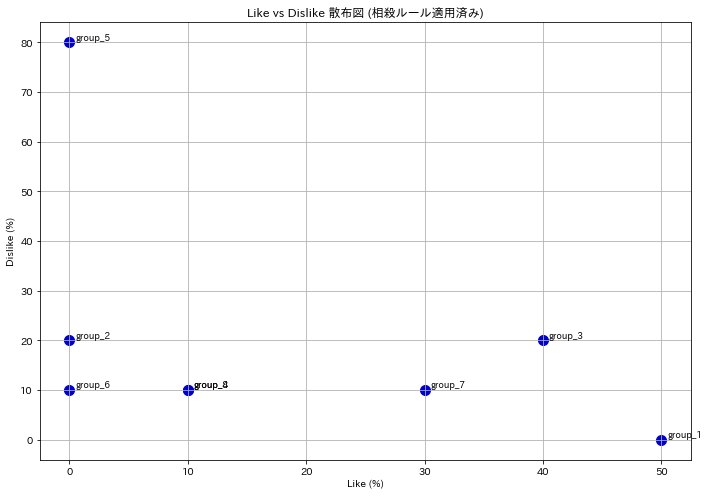

In [7]:

plt.figure(figsize=(10,7))

# 0〜1の比率を100倍してパーセントに
x = df["like_ratio"] * 100
y = df["dislike_ratio"] * 100

plt.scatter(x, y, s=100, color="mediumblue")
for area, row in df.iterrows():
    plt.text(row["like_ratio"] * 100 + 0.5, row["dislike_ratio"] * 100 + 0.5, area, fontsize=9)

plt.xlabel("Like (%)")
plt.ylabel("Dislike (%)")

plt.title("Like vs Dislike 散布図 (相殺ルール適用済み)")
plt.grid(True)
plt.tight_layout()
plt.show()

In [8]:
# ルール前

# per_respondent_area を元に DataFrame を作る
records = []
for respondent_id, areas in per_respondent_area.items():
    record = {"Respondent ID": respondent_id}
    for area, counts in areas.items():
        record[f"{area}_Like"] = counts["like"]
        record[f"{area}_Dislike"] = counts["dislike"]
    records.append(record)

respondent_df = pd.DataFrame(records)
respondent_df = respondent_df.fillna(0).astype({"Respondent ID": int})


# カラム並び順を調整
column_order = ["Respondent ID"]

def extract_group_number(col):
    match = re.search(r"group_(\d+)_", col)
    return int(match.group(1)) if match else float('inf')

like_dislike_cols = [col for col in respondent_df.columns if col != "Respondent ID"]
like_cols = sorted([col for col in like_dislike_cols if "Like" in col], key=extract_group_number)
dislike_cols = sorted([col for col in like_dislike_cols if "Dislike" in col], key=extract_group_number)
column_order += [val for pair in zip(like_cols, dislike_cols) for val in pair]

# カラムを並び替えて、IDを昇順にソート
respondent_df = respondent_df[column_order].sort_values("Respondent ID").reset_index(drop=True)

respondent_df.to_csv("rule_area_count.csv", index=False)
respondent_df

,Respondent ID,group_1_Like,group_1_Dislike,group_2_Like,group_2_Dislike,group_3_Like,group_3_Dislike,group_4_Like,group_4_Dislike,group_5_Like,group_5_Dislike,group_6_Like,group_6_Dislike,group_7_Like,group_7_Dislike,group_8_Like,group_8_Dislike
0,0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0,1,0.0,0.0,1.0,0.0,0.0,0.0
1,1,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0,1,0.0,1.0,0.0,0.0,0.0,0.0
2,2,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0,1,0.0,0.0,0.0,1.0,0.0,0.0
3,3,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0,1,0.0,0.0,1.0,1.0,0.0,0.0
4,4,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0,1,0.0,0.0,0.0,0.0,0.0,1.0
5,5,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0,1,0.0,0.0,1.0,0.0,0.0,0.0
6,6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1,1,0.0,0.0,0.0,0.0,0.0,0.0
7,7,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1,1,0.0,0.0,1.0,0.0,0.0,0.0
8,8,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0,1,0.0,0.0,0.0,0.0,0.0,0.0
9,9,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0,1,0.0,0.0,0.0,0.0,1.0,0.0


In [9]:
#　ルールあと

# 各回答者 × エリア のルール適用後のデータを再集計
records = []
for respondent_id, area_data in per_respondent_area.items():
    record = {"Respondent ID": respondent_id}
    for area, counts in area_data.items():
        like_count = counts["like"]
        dislike_count = counts["dislike"]
        if like_count > 0 and dislike_count > 0:
            # 相殺 → どちらも記録しない
            continue
        if like_count > 0:
            record[f"{area}_Like"] = like_count
        if dislike_count > 0:
            record[f"{area}_Dislike"] = dislike_count
    records.append(record)

# DataFrameに変換
respondent_rule_applied_df = pd.DataFrame(records).fillna(0).astype({"Respondent ID": int})

# カラム名から存在する group番号を抽出して昇順ソート
group_nums = set()
for col in respondent_rule_applied_df.columns:
    m = re.match(r"group_(\d+)_", col)
    if m:
        group_nums.add(int(m.group(1)))
group_nums = sorted(group_nums)

# カラム並び順を作成（group番号順に Like → Dislike の順）
column_order = ["Respondent ID"]
for n in group_nums:
    like_col = f"group_{n}_Like"
    dislike_col = f"group_{n}_Dislike"
    if like_col in respondent_rule_applied_df.columns:
        column_order.append(like_col)
    if dislike_col in respondent_rule_applied_df.columns:
        column_order.append(dislike_col)

# 並べ替え＆出力
respondent_rule_applied_df = respondent_rule_applied_df[column_order].sort_values("Respondent ID").reset_index(drop=True)
respondent_rule_applied_df.to_csv("rule_area_count_after.csv", index=False)


respondent_rule_applied_df

,Respondent ID,group_1_Like,group_2_Dislike,group_3_Like,group_3_Dislike,group_4_Like,group_4_Dislike,group_5_Dislike,group_6_Dislike,group_7_Like,group_7_Dislike,group_8_Like,group_8_Dislike
0,0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
1,1,1.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0
2,2,0.0,0.0,2.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
3,3,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
4,4,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
5,5,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
6,6,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
7,7,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
8,8,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
9,9,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0


In [10]:
#　差分
# 念のため、Respondent ID をキーにしたDataFrameにする
before_df = respondent_df.set_index("Respondent ID")
after_df = respondent_rule_applied_df.set_index("Respondent ID")

# 差分計算（after - before）
diff_df = after_df - before_df
diff_df = diff_df.reset_index()

# 🔽 カラム順を整える：group番号順に Like → Dislike の順
group_nums = set()
for col in diff_df.columns:
    m = re.match(r"group_(\d+)_", col)
    if m:
        group_nums.add(int(m.group(1)))
group_nums = sorted(group_nums)

column_order = ["Respondent ID"]
for n in group_nums:
    like_col = f"group_{n}_Like"
    dislike_col = f"group_{n}_Dislike"
    if like_col in diff_df.columns:
        column_order.append(like_col)
    if dislike_col in diff_df.columns:
        column_order.append(dislike_col)

# 並び替え＆出力
diff_df = diff_df[column_order]
diff_df.to_csv("area_count_diff.csv", index=False)
diff_df

,Respondent ID,group_1_Like,group_1_Dislike,group_2_Like,group_2_Dislike,group_3_Like,group_3_Dislike,group_4_Like,group_4_Dislike,group_5_Like,group_5_Dislike,group_6_Like,group_6_Dislike,group_7_Like,group_7_Dislike,group_8_Like,group_8_Dislike
0,0,0.0,NaN,NaN,0.0,0.0,0.0,0.0,0.0,NaN,0.0,NaN,0.0,0.0,0.0,0.0,0.0
1,1,0.0,NaN,NaN,0.0,0.0,0.0,0.0,0.0,NaN,0.0,NaN,0.0,0.0,0.0,0.0,0.0
2,2,0.0,NaN,NaN,0.0,0.0,0.0,0.0,0.0,NaN,0.0,NaN,0.0,0.0,0.0,0.0,0.0
3,3,0.0,NaN,NaN,0.0,0.0,0.0,0.0,0.0,NaN,0.0,NaN,0.0,-1.0,-1.0,0.0,0.0
4,4,0.0,NaN,NaN,0.0,0.0,0.0,0.0,0.0,NaN,0.0,NaN,0.0,0.0,0.0,0.0,0.0
5,5,0.0,NaN,NaN,0.0,0.0,0.0,0.0,0.0,NaN,0.0,NaN,0.0,0.0,0.0,0.0,0.0
6,6,0.0,NaN,NaN,0.0,0.0,0.0,0.0,0.0,NaN,-1.0,NaN,0.0,0.0,0.0,0.0,0.0
7,7,0.0,NaN,NaN,0.0,0.0,0.0,0.0,0.0,NaN,-1.0,NaN,0.0,0.0,0.0,0.0,0.0
8,8,0.0,NaN,NaN,0.0,-1.0,-1.0,0.0,0.0,NaN,0.0,NaN,0.0,0.0,0.0,0.0,0.0
9,9,0.0,NaN,NaN,0.0,0.0,0.0,0.0,0.0,NaN,0.0,NaN,0.0,0.0,0.0,0.0,0.0


In [11]:
# ルール後のxy 出力用リスト
rows = []

for idx, row in data_df.iterrows():
    respondent_id = row.get("Respondent ID", idx)

    # 各座標の保持
    output_row = {
        "Respondent ID": respondent_id,
        "like1_x": np.nan, "like1_y": np.nan,
        "like2_x": np.nan, "like2_y": np.nan,
        "Dislike1_x": np.nan, "Dislike1_y": np.nan,
        "Dislike2_x": np.nan, "Dislike2_y": np.nan,
    }

    # エリア別記録（like/dislike）→ 各座標がどのエリアに属するかを記録
    like_areas = {}
    dislike_areas = {}

    # likeの座標
    for i in range(1, 3):
        x, y = row.get(f"like{i}_x"), row.get(f"like{i}_y")
        if pd.notnull(x) and pd.notnull(y):
            for area_name, poly in area_polygons.items():
                if poly.contains_point((x, y)):
                    like_areas[i] = area_name
                    break

    # dislikeの座標
    for i in range(1, 3):
        x, y = row.get(f"Dislike{i}_x"), row.get(f"Dislike{i}_y")
        if pd.notnull(x) and pd.notnull(y):
            for area_name, poly in area_polygons.items():
                if poly.contains_point((x, y)):
                    dislike_areas[i] = area_name
                    break

    # 相殺チェック
    canceled_areas = set(like_areas.values()) & set(dislike_areas.values())

    # 生き残った like 座標だけ出力に
    for i in range(1, 3):
        if i in like_areas and like_areas[i] not in canceled_areas:
            output_row[f"like{i}_x"] = row.get(f"like{i}_x")
            output_row[f"like{i}_y"] = row.get(f"like{i}_y")

    # 生き残った dislike 座標だけ出力に
    for i in range(1, 3):
        if i in dislike_areas and dislike_areas[i] not in canceled_areas:
            output_row[f"Dislike{i}_x"] = row.get(f"Dislike{i}_x")
            output_row[f"Dislike{i}_y"] = row.get(f"Dislike{i}_y")

    # 出力に追加
    rows.append(output_row)

# DataFrame化 & CSV出力（ファイル名は適宜変更）
result_df = pd.DataFrame(rows)
result_df = result_df.sort_values("Respondent ID")  # IDで昇順ソート
result_df.to_csv("rule_xy_points.csv", index=False)
result_df

,Respondent ID,like1_x,like1_y,like2_x,like2_y,Dislike1_x,Dislike1_y,Dislike2_x,Dislike2_y
0,0,557.0,428.0,826.0,705.0,503.0,687.0,349.0,424.0
1,1,380.0,467.0,691.0,408.0,329.0,595.0,769.0,428.0
2,2,225.0,433.0,306.0,451.0,352.0,687.0,791.0,656.0
3,3,NaN,NaN,549.0,629.0,193.0,587.0,NaN,NaN
4,4,529.0,466.0,349.0,447.0,497.0,720.0,1004.0,422.0
5,5,NaN,NaN,823.0,646.0,388.0,714.0,334.0,446.0
6,6,NaN,NaN,NaN,NaN,NaN,NaN,184.0,522.0
7,7,NaN,NaN,781.0,711.0,NaN,NaN,346.0,350.0
8,8,553.0,484.0,NaN,NaN,314.0,588.0,NaN,NaN
9,9,691.0,434.0,999.0,436.0,295.0,706.0,424.0,348.0


In [12]:
print("✅ 処理終了")


✅ 処理終了
